# **Rejection Evaluation**
***

we trained resnet18 on the BUSI dataset using different scoring methods. The output is a csv file containing the scores. let's have a look at it:

In [24]:
import pandas as pd
output_path = r"C:\Computer_Vision\Medical_Images_With_Rejection\OurSolution\failure_detection_benchmark\outputs\BUSI\resnet18\dropout_all_layers_autolr_longer\seed_55\failure_detection\scores_df.csv"
scores_df = pd.read_csv(output_path)
scores_df.head()

,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_probas,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score
0,0,0,True,0.958558,-0.086309,0.972900,0,NaN,-0.124704,0,0,0.825654,2.616991,0.908217,0,0,0.995221
1,0,0,True,0.952512,-0.100818,0.949624,0,NaN,-0.234416,0,0,0.819866,1.630859,0.901563,0,0,0.575066
2,0,0,True,0.999833,-0.000334,0.999839,0,NaN,-0.001577,0,0,0.972827,4.571317,0.999625,0,0,0.999988
3,0,0,True,0.998515,-0.002974,0.998244,0,NaN,-0.012959,0,0,0.944680,3.898869,0.996726,0,0,0.999941
4,0,0,True,0.999487,-0.001026,0.999556,0,NaN,-0.003956,0,0,0.967362,4.679353,0.998785,0,0,0.999264


We can see that the classes were encoded as 0,1,2. In general, normal is encoded as 0, benign is encoded as 1 and malignant is encoded as 2.
The dataframe consists of the following columns:
* Targets - Our GT classes.
* Predictions - The predicted classes
* IsCorrect - Is that classification correct or not?
* Baseline - Baseline softmax scorer.
* doctor_alpha - It is a scorer that quantifies the likelihood of being misclassified , and thus negative (as stated in the article).
* mcmc-soft-scores, mcmc-entropy scores - From the paper: "MC-dropout (MC): Gal & Ghahramani (2016) showed that training a neural network with dropout
regularization (Srivastava et al., 2014) produces a Bayesian approximation of the posterior, where the
approximation is obtained by Monte-Carlo sampling of the network’s parameters i.e. by applying
dropout at test-time and averaging the outputs over several inference passes. The confidence in
the prediction can then be approximated by the negative entropy of the outputs; or by taking the
softmax confidence score on the averaged outputs."
* mcmc predictions - predictions made by using Monte-Carlo sampling on the network's parameters.
* mcmc_probas - probabilities of the predictions for monte-carlo sampling (We can notice that it contains NaN values, we might consider dropping it).
* Laplace_targets - The targets for the laplace method. They are the same as the general targets.
* Laplace predictions - predictions made by Laplace
* Laplace score -Laplace confidence score
* TrustScore - Score made by TrustScore scorer.
* ConfidNet score- scores made by ConfidNet
* SWAG_targets - targets for SWAG method. The same as the general targets.
* SWAG_predictions - The predictions made by SWAG
* SWAG_score - SWAG confidence scores

We used The Baseline scorer, doctor-alpha, MC- softmax, MC- entropy, Laplace, TrustScore, ConfidNet, and SWAG (8 overall). The ones missing (as compared to the paper) are DUQ (which we failed to train due to insufficient CUDA memory) and ensemble (we used only 1 seed so ensemble is irrelevant).


Let's focus on that mcmc_probas column. let's check how many missing values it has:

In [25]:
print(f'{scores_df["mcmc_probas"].isna().sum() / len(scores_df["mcmc_probas"]) * 100} % missing values in mcmc_probas column')

100.0 % missing values in mcmc_probas column


Since all values in this column are missing, we will just drop it:

In [26]:
scores_df = scores_df.drop(columns=['mcmc_probas'])
scores_df.head()

,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score
0,0,0,True,0.958558,-0.086309,0.972900,0,-0.124704,0,0,0.825654,2.616991,0.908217,0,0,0.995221
1,0,0,True,0.952512,-0.100818,0.949624,0,-0.234416,0,0,0.819866,1.630859,0.901563,0,0,0.575066
2,0,0,True,0.999833,-0.000334,0.999839,0,-0.001577,0,0,0.972827,4.571317,0.999625,0,0,0.999988
3,0,0,True,0.998515,-0.002974,0.998244,0,-0.012959,0,0,0.944680,3.898869,0.996726,0,0,0.999941
4,0,0,True,0.999487,-0.001026,0.999556,0,-0.003956,0,0,0.967362,4.679353,0.998785,0,0,0.999264


Let's check for missing values once again:

In [27]:
print(f'{scores_df.isna().sum().sum() / scores_df.shape[0] * 100} % missing values in the dataframe')

0.0 % missing values in the dataframe


## **Thresholding**
***

Now that we have no missing values in the dataframe, we can find thresholds for separating the correct classifications from the incorrect ones, for each class and scoring method:

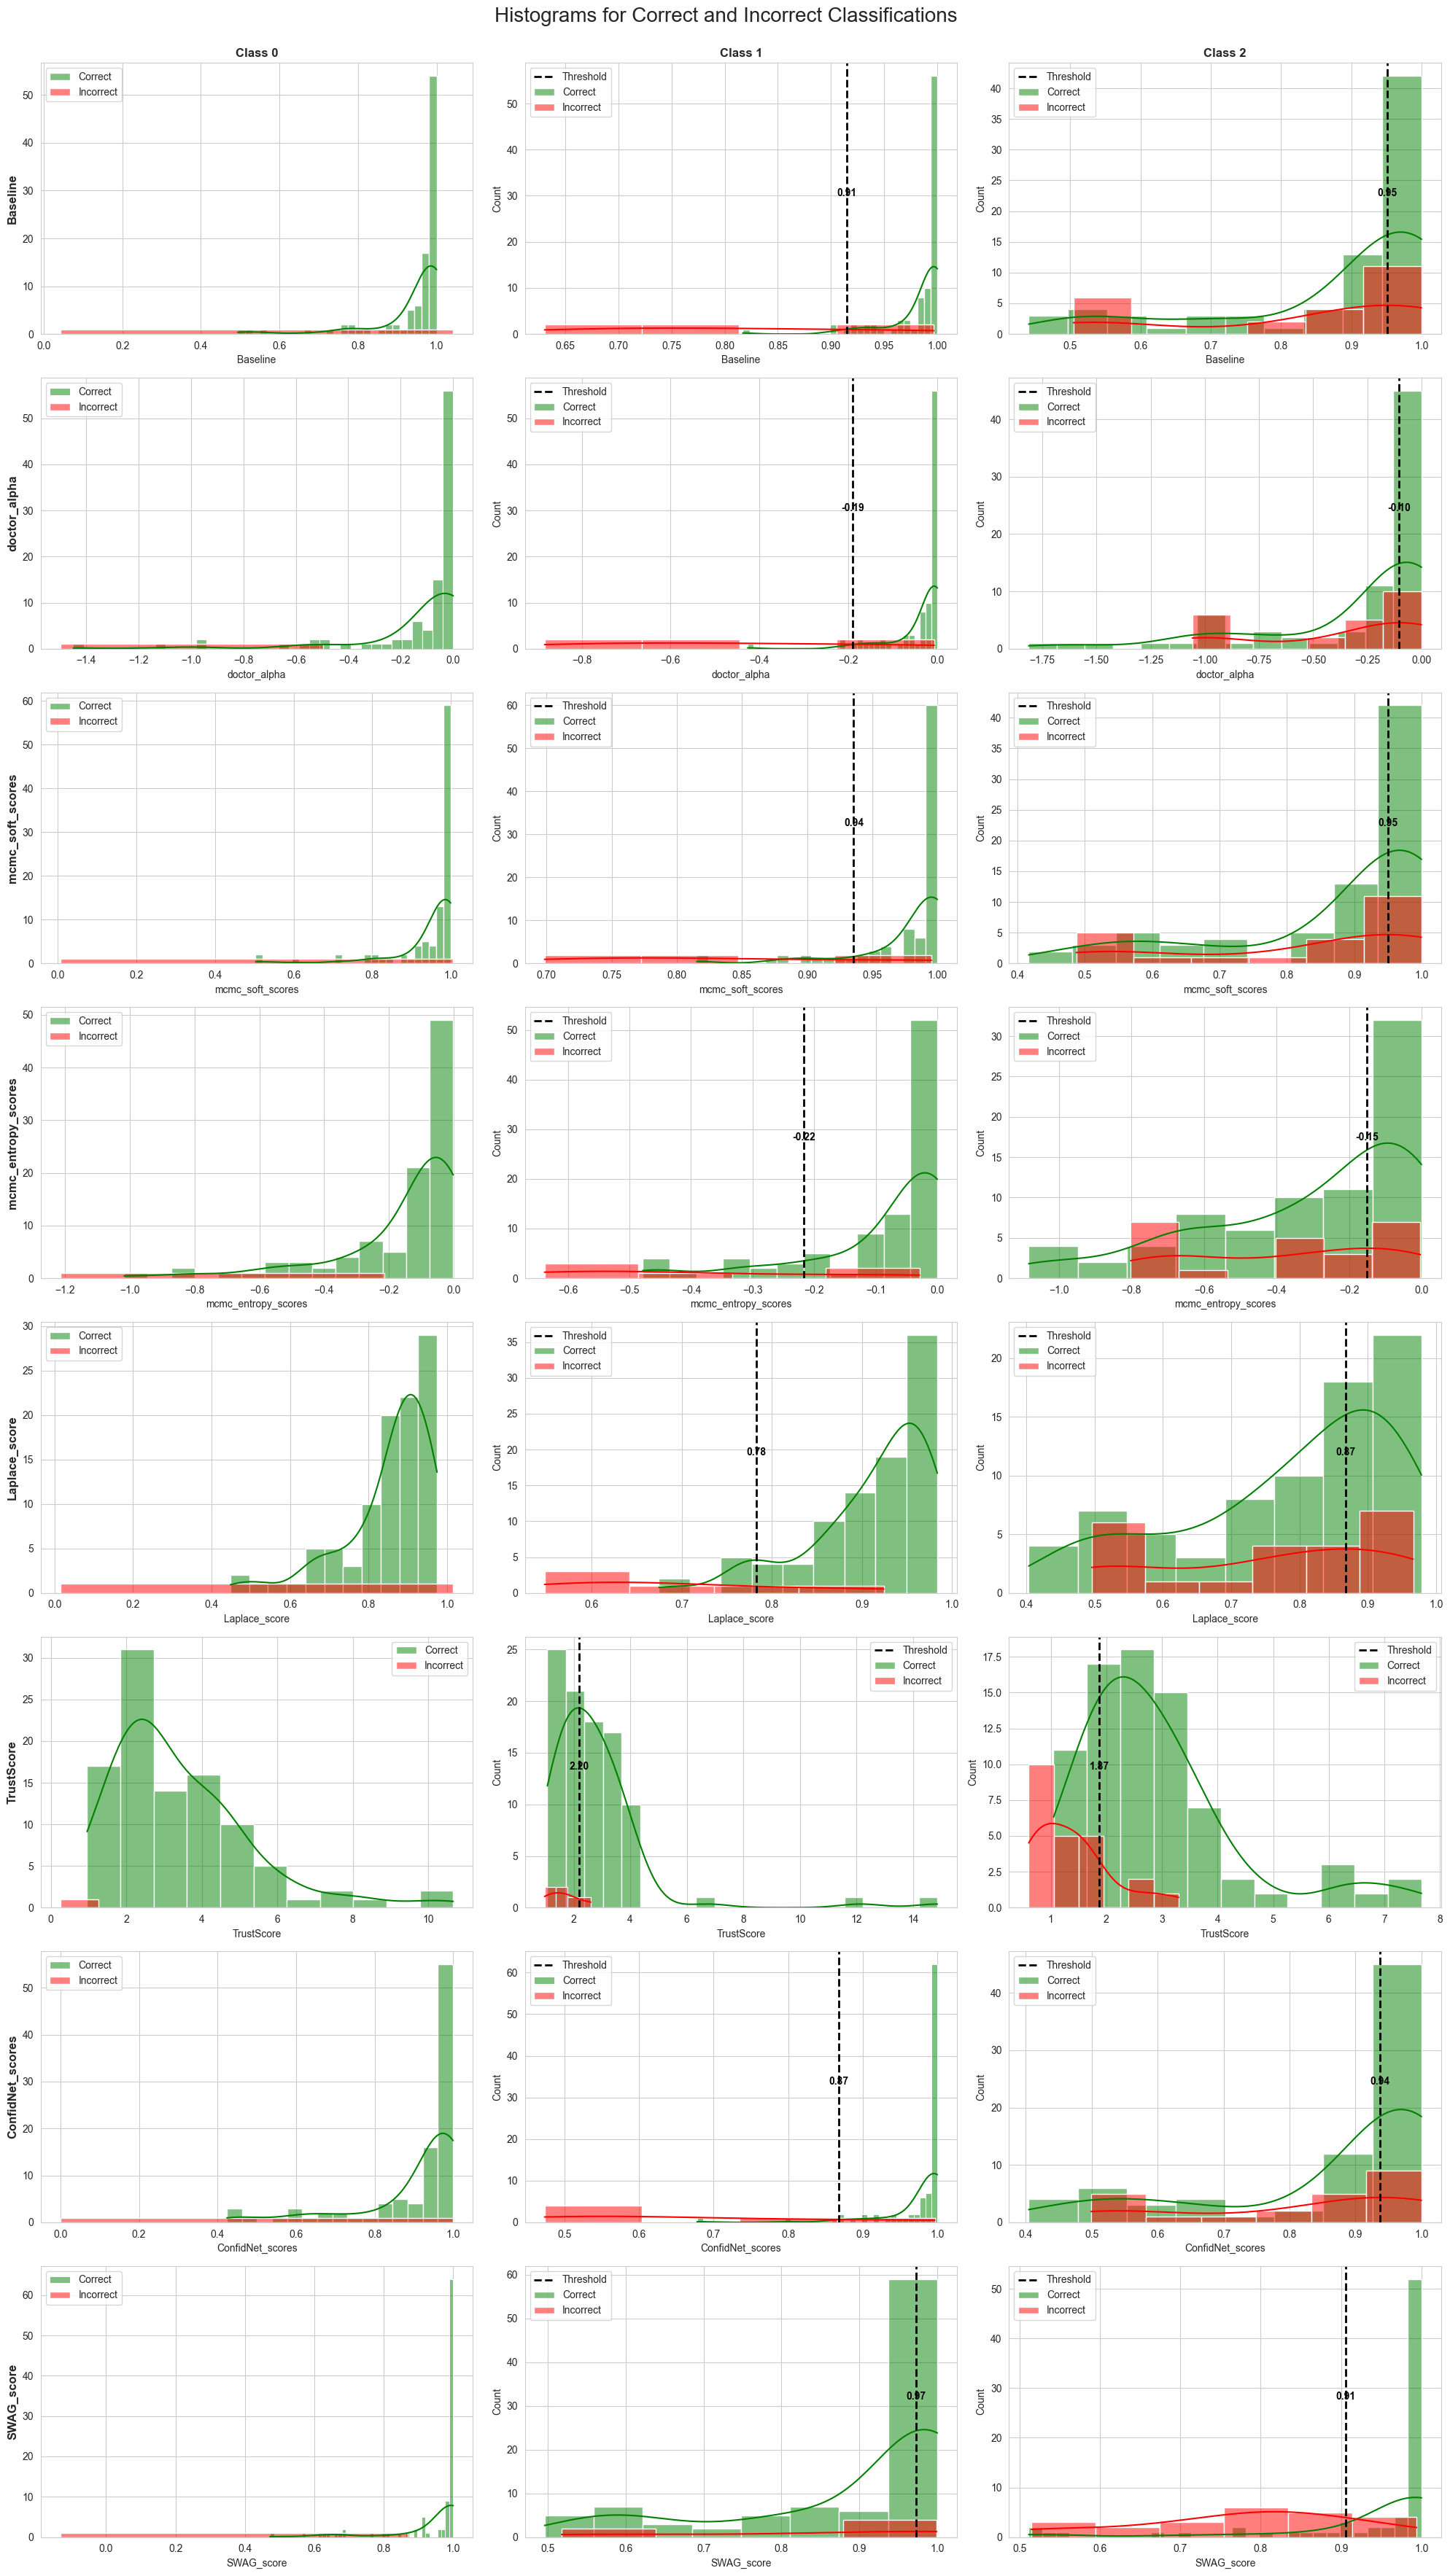

In [28]:
# Necessary Imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define scoring methods
scoring_methods = [
    'Baseline', 'doctor_alpha', 'mcmc_soft_scores', 'mcmc_entropy_scores',
    'Laplace_score', 'TrustScore', 'ConfidNet_scores', 'SWAG_score'
]

# Extract unique classes from the dataframe
classes = scores_df["Targets"].unique()

# Create a figure with 8 rows and 3 columns (8 scoring methods x 3 classes)
fig, axes = plt.subplots(nrows=len(scoring_methods), ncols=len(classes), figsize=(20, 36))  # Increased figsize

fig.subplots_adjust(top=0.93,hspace=0.5)  # Adjust top to create space for the suptitle

# Add suptitle above the subplots
plt.subplots_adjust(top=0.93, hspace=0.5)  # Adjust overall top margin and add blank space with hspace
fig.suptitle('Histograms for Correct and Incorrect Classifications', fontsize=20, y=0.98)

thresholds = {}

for row, method in enumerate(scoring_methods):
    for col, cls in enumerate(classes):
        # Get the appropriate axis for this subplot
        ax = axes[row, col]

        # Separate the data into correct and incorrect classifications for the current class and scoring method
        correct = scores_df[(scores_df['Targets'] == cls) & (scores_df['IsCorrect'] == True)][method]
        incorrect = scores_df[(scores_df['Targets'] == cls) & (scores_df['IsCorrect'] == False)][method]

        # Find the optimal threshold using KDE without clearing histograms
        x_vals = np.linspace(min(scores_df[method]), max(scores_df[method]), 1000)

        if len(correct) >= 2:
            correct_kde = sns.kdeplot(correct, ax=ax).get_lines()[0].get_data()
        else:
            correct_kde = None

        if len(incorrect) >= 2:
            incorrect_kde = sns.kdeplot(incorrect, ax=ax).get_lines()[1].get_data()

        else:
            incorrect_kde = None

        ax.clear()

        # Plot histograms
        sns.histplot(correct, kde=True, color='green', label='Correct', ax=ax)
        sns.histplot(incorrect, kde=True, color='red', label='Incorrect', ax=ax)

        correct_interp = None
        incorrect_interp = None

        if correct_kde is not None:
            correct_interp = np.interp(x_vals, correct_kde[0], correct_kde[1])

        if incorrect_kde is not None:
            incorrect_interp = np.interp(x_vals, incorrect_kde[0], incorrect_kde[1])


        if correct_interp is not None and incorrect_interp is not None:
            overlap_vals = np.minimum(correct_interp, incorrect_interp)
            total_overlap_area = np.trapz(overlap_vals, x_vals)  # Compute area of overlap using np.trapz

            thresholds[(method, cls)] = x_vals[np.argmax(overlap_vals)]  # Minimizes overlap

            # Add threshold to the plot
            threshold = thresholds[(method, cls)]
            ax.axvline(x=threshold, color='black', linestyle='dashed', linewidth=2, label='Threshold')
            ax.text(threshold, 0.5 * ax.get_ylim()[1], f'{threshold:.2f}', color='black', fontsize=10, ha='center', va='bottom', fontweight='bold')

        # Set titles and labels
        if col == 0:
            ax.set_ylabel(method, fontsize=12, fontweight='bold')
        if row == 0:
            ax.set_title(f'Class {cls}', fontsize=12, fontweight='bold')

        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.98])    # Ensures better layout of the plots
plt.show()

In [29]:
# Identify rows where the values of 'Targets' and 'SWAG_targets' differ
swag_inconsistent_rows = scores_df[
    scores_df["Targets"] != scores_df["SWAG_targets"]
]

# Identify rows where the values of 'Targets' and 'Laplace_targets' differ
laplace_inconsistent_rows = scores_df[
    scores_df["Targets"] != scores_df["Laplace_targets"]
]

# Print rows where 'SWAG_targets' differ from 'Targets'
print("Rows where 'SWAG_targets' differ from 'Targets':")
display(swag_inconsistent_rows)

# Print rows where 'Laplace_targets' differ from 'Targets'
print("\nRows where 'Laplace_targets' differ from 'Targets':")
laplace_inconsistent_rows

Rows where 'SWAG_targets' differ from 'Targets':


,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score



Rows where 'Laplace_targets' differ from 'Targets':


,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score


In [30]:
laplace_inconsistent_rows["Laplace_targets"].unique()

array([], dtype=int64)

In [31]:
scores_df.shape

(300, 16)

In [32]:
scores_df[scores_df["Targets"] == 0]

,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score
0,0,0,True,0.958558,-0.086309,0.972900,0,-0.124704,0,0,0.825654,2.616991,0.908217,0,0,0.995221
1,0,0,True,0.952512,-0.100818,0.949624,0,-0.234416,0,0,0.819866,1.630859,0.901563,0,0,0.575066
2,0,0,True,0.999833,-0.000334,0.999839,0,-0.001577,0,0,0.972827,4.571317,0.999625,0,0,0.999988
3,0,0,True,0.998515,-0.002974,0.998244,0,-0.012959,0,0,0.944680,3.898869,0.996726,0,0,0.999941
4,0,0,True,0.999487,-0.001026,0.999556,0,-0.003956,0,0,0.967362,4.679353,0.998785,0,0,0.999264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,True,0.944223,-0.117733,0.948272,0,-0.203602,0,0,0.761150,2.560473,0.876686,0,0,0.996527
96,0,0,True,0.993867,-0.012341,0.994875,0,-0.032222,0,0,0.911623,3.081030,0.988573,0,0,0.999671
97,0,0,True,0.969001,-0.064161,0.971294,0,-0.141817,0,0,0.848822,2.425415,0.937782,0,0,0.638579
98,0,0,True,0.975132,-0.051198,0.980326,0,-0.106747,0,0,0.861092,2.543852,0.947884,0,0,0.685058


In [33]:
incorrect_classifications = scores_df[(scores_df['IsCorrect'] == False)]
incorrect_classifications

,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score
93,0,1,False,0.542199,-0.996571,0.506328,1,-0.714512,0,1,0.515201,0.753894,0.500018,0,1,0.368445
109,1,0,False,0.920524,-0.172043,0.959860,0,-0.176751,1,0,0.786813,1.715837,0.801929,1,0,0.987456
130,1,0,False,0.694464,-0.744224,0.698486,0,-0.637902,1,0,0.592708,1.115700,0.493597,1,0,0.612314
140,1,0,False,0.630572,-0.883516,0.754610,0,-0.576412,1,0,0.547877,0.969581,0.473550,1,0,0.976537
159,1,2,False,0.996599,-0.006824,0.995468,2,-0.029070,1,2,0.924214,2.599871,0.996666,1,2,0.999215
166,1,0,False,0.764609,-0.562535,0.793476,0,-0.510422,1,0,0.639268,1.881358,0.575670,1,1,0.517847
188,1,0,False,0.806368,-0.454659,0.815660,0,-0.483251,1,0,0.666524,1.445504,0.596992,1,0,0.965686
200,2,1,False,0.516394,-0.997864,0.607124,1,-0.670071,2,1,0.506924,0.691899,0.591513,2,2,0.776431
205,2,1,False,0.999558,-0.000885,0.999096,1,-0.007267,2,1,0.962905,2.806211,0.999674,2,1,0.769955
206,2,1,False,0.504509,-1.001041,0.530463,2,-0.696400,2,1,0.498532,0.760001,0.523530,2,2,0.788923


In [34]:
scores_df[scores_df["Targets"] == 1]

,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score
100,1,1,True,0.999357,-0.001287,0.998886,1,-0.008737,1,1,0.954454,2.604251,0.999645,1,1,0.981110
101,1,1,True,0.998616,-0.002772,0.997317,1,-0.018820,1,1,0.958854,3.322843,0.999147,1,1,0.992030
102,1,1,True,0.999994,-0.000011,0.999990,1,-0.000131,1,1,0.980289,3.996757,0.999988,1,1,0.999771
103,1,1,True,0.999659,-0.000682,0.999233,1,-0.006716,1,1,0.963480,3.204413,0.999525,1,1,0.962435
104,1,1,True,0.993956,-0.012160,0.991273,1,-0.050142,1,1,0.903157,2.400910,0.994988,1,1,0.993107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,1,True,0.985064,-0.030421,0.982564,1,-0.099019,1,1,0.911488,1.538973,0.979422,1,2,0.914000
196,1,1,True,0.985696,-0.029018,0.979401,1,-0.100486,1,1,0.877913,2.407808,0.983907,1,1,0.979130
197,1,1,True,0.964702,-0.073317,0.955595,1,-0.193344,1,1,0.867869,1.163538,0.970824,1,1,0.846762
198,1,1,True,0.999939,-0.000121,0.999893,1,-0.001112,1,1,0.972647,3.101205,0.999875,1,1,0.999694


In [35]:
scores_df[scores_df["Targets"] == 2]

,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score
200,2,1,False,0.516394,-0.997864,0.607124,1,-0.670071,2,1,0.506924,0.691899,0.591513,2,2,0.776431
201,2,2,True,0.812842,-0.438406,0.845361,2,-0.440260,2,2,0.676589,2.311351,0.751007,2,2,0.999235
202,2,2,True,0.513696,-0.998889,0.622645,2,-0.664108,2,2,0.502619,1.049000,0.527940,2,2,0.991812
203,2,2,True,0.902859,-0.213168,0.903451,2,-0.328413,2,2,0.755685,1.940250,0.884653,2,2,0.976732
204,2,2,True,0.843225,-0.366864,0.815071,2,-0.539070,2,2,0.713264,1.786319,0.821045,2,0,0.547533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2,2,True,0.493696,-1.629705,0.460968,2,-1.063581,2,2,0.438296,1.552256,0.415909,2,2,0.997917
296,2,2,True,0.540461,-1.494820,0.501732,2,-1.036933,2,2,0.465907,1.607867,0.419982,2,2,0.999080
297,2,2,True,0.440932,-1.812537,0.416876,2,-1.083334,2,2,0.403400,1.484334,0.404618,2,2,0.998708
298,2,2,True,0.896854,-0.233429,0.904863,2,-0.373676,2,2,0.711639,2.062478,0.860186,2,2,0.906261


In [36]:
from sklearn.metrics import roc_auc_score

# Initialize an empty dictionary to store AUC results
auc_results = {"Class": [], "Scoring Method": [], "AUC": []}

# Iterate through each class
classes = scores_df["Targets"].unique()
scoring_methods = ["Baseline", "doctor_alpha", "mcmc_soft_scores", "mcmc_entropy_scores",
                   "Laplace_score", "TrustScore", "ConfidNet_scores", "SWAG_score"]

for cls in classes:
    class_df = scores_df[scores_df["Targets"] == cls]  # Filter dataframe for current class

    for method in scoring_methods:
        try:
            # Calculate AUC for the current class and scoring method
            auc = roc_auc_score(class_df["IsCorrect"].astype(int), class_df[method])
            auc_results["Class"].append(cls)
            auc_results["Scoring Method"].append(method)
            auc_results["AUC"].append(auc)
        except ValueError:
            # If AUC cannot be calculated (e.g., due to lack of variability), append NaN
            auc_results["Class"].append(cls)
            auc_results["Scoring Method"].append(method)
            auc_results["AUC"].append(None)

# Create a DataFrame from AUC results
auc_df = pd.DataFrame(auc_results)

# Display the AUC results DataFrame
auc_df

,Class,Scoring Method,AUC
0,0,Baseline,0.979798
1,0,doctor_alpha,0.979798
2,0,mcmc_soft_scores,0.989899
3,0,mcmc_entropy_scores,0.969697
4,0,Laplace_score,0.979798
5,0,TrustScore,1.000000
6,0,ConfidNet_scores,0.959596
7,0,SWAG_score,1.000000
8,1,Baseline,0.914894
9,1,doctor_alpha,0.913121
